In [3]:
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from spektral.datasets import qm9
from spektral.layers import EdgeConditionedConv, GlobalAttentionPool
from spektral.utils import label_to_one_hot

Using TensorFlow backend.
/Users/em/anaconda3/envs/venv/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [4]:
A, X, E, y = qm9.load_data(return_type='numpy',
                           nf_keys='atomic_num',
                           ef_keys='type',
                           self_loops=True,
                           amount=1000)  # Set to None to train on whole dataset
y = y[['cv']].values  # Heat capacity at 298.15K

Loading QM9 dataset.
Reading SDF


100%|██████████| 1000/1000 [00:00<00:00, 6714.56it/s]


In [5]:
uniq_X = np.unique(X)
X = label_to_one_hot(X, uniq_X)
uniq_E = np.unique(E)
ef = label_to_one_hot(E, uniq_E)
y = StandardScaler().fit_transform(y).reshape(-1, y.shape[-1])

In [6]:
N = X.shape[-2]           # Number of nodes in the graphs
F = X.shape[-1]           # Node features dimensionality
S = E.shape[-1]           # Edge features dimensionality
n_out = y.shape[-1]       # Dimensionality of the target
learning_rate = 1e-3      # Learning rate for SGD
epochs = 25               # Number of training epochs
batch_size = 64           # Batch size
es_patience = 5           # Patience fot early stopping

In [7]:
A_train, A_test, \
X_train, X_test, \
E_train, E_test, \
y_train, y_test = train_test_split(A, X, E, y, test_size=0.1)

In [8]:
X_in = Input(shape=(N, F))
A_in = Input(shape=(N, N))
E_in = Input(shape=(N, N, S))

W1001 10:54:44.408653 4474283456 deprecation_wrapper.py:119] From /Users/em/anaconda3/envs/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1001 10:54:44.422243 4474283456 deprecation_wrapper.py:119] From /Users/em/anaconda3/envs/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [9]:
gc1 = EdgeConditionedConv(64, activation='relu')([X_in, A_in, E_in])
gc2 = EdgeConditionedConv(128, activation='relu')([gc1, A_in, E_in])
pool = GlobalAttentionPool(256)(gc2)
dense1 = Dense(256, activation='relu')(pool)

W1001 10:54:44.777466 4474283456 deprecation_wrapper.py:119] From /Users/em/anaconda3/envs/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [10]:
output = Dense(n_out)(dense1)

In [11]:
model = Model(inputs=[X_in, A_in, E_in], outputs=output)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

W1001 10:54:45.531251 4474283456 deprecation_wrapper.py:119] From /Users/em/anaconda3/envs/venv/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 5)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 8, 8)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 8, 8, 1)      0                                            
__________________________________________________________________________________________________
edge_conditioned_conv_1 (EdgeCo (None, 8, 64)        704         input_1[0][0]                    
                                                                 input_2[0][0]              

In [12]:
es_callback = EarlyStopping(monitor='val_loss', patience=es_patience)

In [21]:
model.fit([X_train, A_train, E_train],
          y_train,
          batch_size=batch_size,
          validation_split=0.1,
          epochs=epochs,
          callbacks=[es_callback])

Train on 810 samples, validate on 90 samples
Epoch 1/25
810/810 [==============================] - 4s 5ms/step - loss: 0.3622 - val_loss: 0.2512
Epoch 2/25
810/810 [==============================] - 4s 5ms/step - loss: 0.2336 - val_loss: 0.1794
Epoch 3/25
810/810 [==============================] - 4s 5ms/step - loss: 0.1974 - val_loss: 0.1609
Epoch 4/25
810/810 [==============================] - 4s 5ms/step - loss: 0.1857 - val_loss: 0.1316
Epoch 5/25
810/810 [==============================] - 4s 5ms/step - loss: 0.1825 - val_loss: 0.1197
Epoch 6/25
810/810 [==============================] - 4s 5ms/step - loss: 0.1613 - val_loss: 0.1282
Epoch 7/25
810/810 [==============================] - 4s 5ms/step - loss: 0.1306 - val_loss: 0.0955
Epoch 8/25
810/810 [==============================] - 4s 5ms/step - loss: 0.1055 - val_loss: 0.0864
Epoch 9/25
810/810 [==============================] - 4s 5ms/step - loss: 0.0967 - val_loss: 0.0709
Epoch 10/25
810/810 [==============================] - 

KeyboardInterrupt: 

In [14]:
print('Evaluating model.')
eval_results = model.evaluate([X_test, A_test, E_test],
                              y_test,
                              batch_size=batch_size)
print('Done.\n'
      'Test loss: {}'.format(eval_results))

Evaluating model.
100/100 [==============================] - 0s 3ms/step
Done.
Test loss: 0.34165983319282534


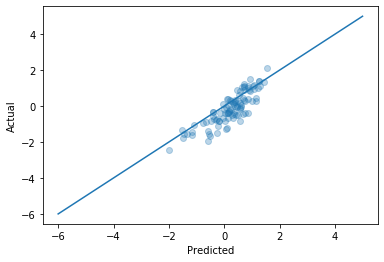

In [15]:
preds = model.predict([X_test, A_test, E_test])

plt.figure()
plt.scatter(preds, y_test, alpha=0.3)
plt.plot(range(-6, 6), range(-6, 6))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('pred_v_true.png')

In [1]:
def find_rsq(preds, y_test):
    mean = np.mean(y_test)
    s_res = 0
    s_tot = 0
    for x in range(len(preds)):
        s_res += (y_test[x] - preds[x])[0]**2
        s_tot += (y_test[x] - mean)[0]**2
    r_sq = 1 - (s_res / s_tot)
    return r_sq

In [16]:
print(find_rsq(preds, y_test))

0.5745842319714364
